# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV  # Note, this is only available for sklearn v0.16.1
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
    for i in range(num_examples):
        print(f"{i} TEXT:\n{train_data[i]}")
        print(f"{i} LABEL: {train_labels[i]} = {newsgroups_train.target_names[train_labels[i]]}\n")
    
P1()

0 TEXT:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
0 LABEL: 1 = comp.graphics

1 TEXT:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
1 LABEL: 3 = talk

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
    vectorizer = CountVectorizer()
    transformed_train_data = vectorizer.fit_transform(train_data)
    
    # a
    print(f"Vocabulary Size: {transformed_train_data.shape[1]}")

    non_zero_feature_count = 0
    for entry in transformed_train_data:
        non_zero_feature_count += entry.nnz
    print(f"Average # of non-zero features: {non_zero_feature_count/transformed_train_data.shape[0]}")
    
    all_entries_count = transformed_train_data.shape[0] * transformed_train_data.shape[1]
    non_zero_entries_count = transformed_train_data.nnz
    print(f"Non-zero fraction (shown as percentage): {non_zero_entries_count/all_entries_count}")
    
    # b
    print(f"First feature string: {vectorizer.get_feature_names()[0]}")
    print(f"Last feature string: {vectorizer.get_feature_names()[-1]}")

    # c
    vocab = ["atheism", "graphics", "space", "religion"]
    fixed_vocab_vectorizer = CountVectorizer(vocabulary=vocab)
    fixed_vocab_transformed_train_data = fixed_vocab_vectorizer.fit_transform(train_data)
    fixed_vocab_non_zero_feature_count = 0
    for entry in fixed_vocab_transformed_train_data:
        fixed_vocab_non_zero_feature_count += entry.nnz
    print(f"Average # of non-zero features for fixed vocab: {fixed_vocab_non_zero_feature_count/fixed_vocab_transformed_train_data.shape[0]}")
    
    # d
    bitrigram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2,3))
    bitrigram_train_data = bitrigram_vectorizer.fit_transform(train_data)
    print(f"Bigram + Trigram Vocabulary Size: {bitrigram_train_data.shape[1]}")
    
    # e
    mindf_vectorizer = CountVectorizer(min_df=10)
    mindf_train_data = mindf_vectorizer.fit_transform(train_data)
    print(f"Min 10 DF Vocabulary Size: {mindf_train_data.shape[1]}")
    
    # f
    dev_vectorizer = CountVectorizer()
    transformed_dev_data = dev_vectorizer.fit_transform(dev_data)
    
    # First attempt at f - Vocabulary size difference
    difference = transformed_train_data.shape[1] - transformed_dev_data.shape[1]
    print(f"Words found in Dev, but not Train fraction (shown as percentage): {difference/transformed_train_data.shape[1]}")

    # Second refined attempt at f - Checks for uniqueness of words in dev vs train
    unique_difference = len(dev_vectorizer.vocabulary_.keys() - vectorizer.vocabulary_.keys())
    print(f"Unique words found in Dev, but not Train fraction (shown as percentage): {unique_difference/transformed_dev_data.shape[1]}")
    
    
P2()

Vocabulary Size: 26879
Average # of non-zero features: 96.70599803343165
Non-zero fraction (shown as percentage): 0.0035978272269590263
First feature string: 00
Last feature string: zyxel
Average # of non-zero features for fixed vocab: 0.26843657817109146
Bigram + Trigram Vocabulary Size: 35478
Min 10 DF Vocabulary Size: 3064
Words found in Dev, but not Train fraction (shown as percentage): 0.395587633468507
Unique words found in Dev, but not Train fraction (shown as percentage): 0.24787640034470024


#### Answers
a) Size of Vocabulary: 26,879
   Average # of non-zero features: 96.70599803343165
   Non-zero fraction (shown as percentage): 0.0035978272269590263

b) First feature string: 00 - Note, the feature strings are sorted with 
   Last feature string:  zyxel

c) Average # of non-zero features for fixed vocab: 0.26843657817109146

d) Bigram + Trigram Vocabulary Size: 35,478

e) Min 10 DF Vocabulary Size: 3,064

f) Following the suggested instructions, I came up with an original answer of 0.395587633468507 - The suggested instructions        seem to compute the difference in Vocabulary size between Train and Dev though.  I believe the question is asking for unique    words in the Dev Data not accounted for in the Train data, and thus came up with the second answer 0.24787640034470024

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [5]:
def P3():
    vectorizer = CountVectorizer()
    transformed_train_data = vectorizer.fit_transform(train_data)
    transformed_dev_data = vectorizer.transform(dev_data)
    
    # KNN w/ optimal k value
    knn = KNeighborsClassifier()
    params = { 'n_neighbors': range(1,25) }
    gscv = GridSearchCV(knn, params, cv=5)
    gscv.fit(transformed_train_data, train_labels)
    f1_score = metrics.f1_score(dev_labels, gscv.predict(transformed_dev_data), average='weighted')
    print(f"Best Params={gscv.best_params_}, F1 Score: {f1_score}")
    
    # Multinomial Naive Bayes w/ optimal alpha
    multinb = MultinomialNB()
    params = { 'alpha': np.linspace(0.01,1.0,25) }
    gscv = GridSearchCV(multinb, params, cv=5)
    gscv.fit(transformed_train_data, train_labels)
    f1_score = metrics.f1_score(dev_labels, gscv.predict(transformed_dev_data), average='weighted')
    print(f"Best Params={gscv.best_params_}, F1 Score: {f1_score}")
    
    # Logistic Regressoin w/ optimal C L2 regularization strength
    best_hash = {'c': 0, 'f1-score': 0.0}
    for c in np.linspace(0.01,1.0,25):
        # Fit and score each Logistic Regression model
        logr = LogisticRegression(penalty='l2', C=c)
        logr.fit(transformed_train_data, train_labels)
        f1_score = metrics.f1_score(dev_labels, logr.predict(transformed_dev_data), average='weighted')
        
        for i, class_array in enumerate(logr.coef_):
            sum = 0
            for weight in class_array:
                sum += weight**2
            print(f"C: {c}, Class: {newsgroups_train.target_names[i]}, Sum: {sum}")
    
        # Update best F1 Score and C value
        if float(f1_score) > best_hash['f1-score']:
            best_hash = {'c': c, 'f1-score': f1_score}
    
    print(f"Best C: {best_hash['c']}, F1 Score: {best_hash['f1-score']}")

    
P3()

Best Params={'n_neighbors': 20}, F1 Score: 0.4243419588207676
Best Params={'alpha': 0.01}, F1 Score: 0.7751663218544357


c:\software\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\software\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


C: 0.01, Class: alt.atheism, Sum: 2.5414725187280784
C: 0.01, Class: comp.graphics, Sum: 2.939709368365917
C: 0.01, Class: sci.space, Sum: 2.8624686773924837
C: 0.01, Class: talk.religion.misc, Sum: 2.2500283736367845
C: 0.051250000000000004, Class: alt.atheism, Sum: 14.418459708752863
C: 0.051250000000000004, Class: comp.graphics, Sum: 13.969263916197658
C: 0.051250000000000004, Class: sci.space, Sum: 14.94527554760488
C: 0.051250000000000004, Class: talk.religion.misc, Sum: 12.152883391946558
C: 0.0925, Class: alt.atheism, Sum: 25.263916043765736
C: 0.0925, Class: comp.graphics, Sum: 23.123787464728448
C: 0.0925, Class: sci.space, Sum: 25.63251519058747
C: 0.0925, Class: talk.religion.misc, Sum: 21.41493419482608
C: 0.13375, Class: alt.atheism, Sum: 35.1976582745767
C: 0.13375, Class: comp.graphics, Sum: 31.215261129631614
C: 0.13375, Class: sci.space, Sum: 35.314690569331404
C: 0.13375, Class: talk.religion.misc, Sum: 30.009873810678563
C: 0.17500000000000002, Class: alt.atheism, Su

#### ANSWER:
KNN - Best K=20, F1 Score: 0.4243419588207676

MultiNB - Best Alpha=0.01, F1 Score: 0.7751663218544357

Logistic Regression - Best C=0.46375, F1 Score: 0.7053736223659037

a) KNN does not work well for this because due to the vast sparsity of our dataset.  In previous KNN models for the class, we had a relatively dense feature set while this problem we find that <1% of our features are active for any given document.

b) MultiNB performs better than Logistic Regression because there is not a large amount of data for Logistic Regression to learn from.  I understand that Logistic Regression tends to out perform other ML Models as data size increases, but in this case we have ~2000 training examples for 4 classes.  

c) The sum and C value are positively correlated.  As seen above, when C is close to 0, the sums are also smaller in value.  When C is closer to 1.0, the sums are starting to reach values above 100.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [6]:
from pandas import DataFrame

def P4():
    # Unigram Features
    vectorizer = CountVectorizer()
    transformed_train_data = vectorizer.fit_transform(train_data)
    feature_names = vectorizer.get_feature_names()
    
    # Create Logistic Regression model
    logr = LogisticRegression(penalty='l2', C=0.46375)
    logr.fit(transformed_train_data, train_labels)
    
    # Determine top 5 features per class
    top_20_features = []
    for i, class_array in enumerate(logr.coef_):
        top_5_feature_weights = np.sort(class_array)[-5:]
        
        # For each weight, determine the word associated with it and add to top features array
        for weight in top_5_feature_weights:
            feature_index = class_array.tolist().index(weight)
            top_20_features.append(feature_names[feature_index])

    # Determine feature weights for top 5 words of each class
    top_20 = {'Feature': top_20_features}
    for class_ in newsgroups_train.target_names:
        top_20[class_] = []
        
    for word in top_20_features:
        for i, class_array in enumerate(logr.coef_):
            word_index = feature_names.index(word)
            weight = class_array[word_index]
            curr_class = newsgroups_train.target_names[i]
            top_20[curr_class].append(weight)
    
    # Output table using Pandas DataFrame
    print(DataFrame(top_20))
                
    # Repeat for bigram features
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
    transformed_train_data = vectorizer.fit_transform(train_data)
    feature_names = vectorizer.get_feature_names()

    # Create Logistic Regression model
    logr = LogisticRegression(penalty='l2', C=0.46375)
    logr.fit(transformed_train_data, train_labels)
    
    # Determine top 5 features per class
    top_20_features = []
    for i, class_array in enumerate(logr.coef_):
        top_5_feature_weights = np.sort(class_array)[-5:]
        
        # For each weight, determine the word associated with it and add to top features array
        for weight in top_5_feature_weights:
            feature_index = class_array.tolist().index(weight)
            top_20_features.append(feature_names[feature_index])

    # Determine feature weights for top 5 words of each class
    top_20 = {'Feature': top_20_features}
    for class_ in newsgroups_train.target_names:
        top_20[class_] = []
        
    for word in top_20_features:
        for i, class_array in enumerate(logr.coef_):
            word_index = feature_names.index(word)
            weight = class_array[word_index]
            curr_class = newsgroups_train.target_names[i]
            top_20[curr_class].append(weight)
    
    # Output table using Pandas DataFrame
    print(DataFrame(top_20))
            
P4()

c:\software\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\software\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


       Feature  alt.atheism  comp.graphics  sci.space  talk.religion.misc
0     deletion     0.689559      -0.236843  -0.259942           -0.259462
1      atheism     0.779350      -0.344442  -0.358624           -0.371297
2     religion     0.782489      -0.497267  -0.645144           -0.048427
3        bobby     0.806191      -0.188118  -0.280645           -0.379123
4     atheists     0.813849      -0.092912  -0.261784           -0.617592
5     computer     0.063935       0.830598  -0.557451           -0.387178
6           3d    -0.297462       0.922372  -0.557659           -0.310854
7         file    -0.269575       1.037974  -0.669393           -0.494241
8        image    -0.457873       1.092694  -0.655879           -0.371036
9     graphics    -0.628904       1.593951  -1.078993           -0.612479
10  spacecraft    -0.291282      -0.314666   0.718486           -0.282896
11      launch    -0.368179      -0.389402   0.767932           -0.274988
12        nasa    -0.454511      -0.40

ANSWER:  I am most surprised by the highest weighted features for atheism since they are mostly prepositions, pronouns, and adjectives.  Most of the other highly weighted features contain nouns and verbs that intuitively pertain to the given class.  

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [7]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    lowercased = s.lower()
    remove_nonalphanumeric = re.sub('[!@#$%^&"`{}<>]', '', lowercased)
    
    # Reducing number sequences impedes F1 score accuracy... so this was omitted
    #reduce_numbers = re.sub(r'[0-9]+', '*', remove_nonalphanumeric)
    
    # Note, any shorter of word cut off seems to impede F1 score accuracy
    shortened_words = []
    for word in remove_nonalphanumeric.split(' '):
        shortened_words.append(word[:100])
    shortened_words = ' '.join(shortened_words)
    
    preprocessed_string = shortened_words
    return preprocessed_string


def P5():
    # No preprocessor
    vectorizer = CountVectorizer(preprocessor=empty_preprocessor)
    transformed_train_data = vectorizer.fit_transform(train_data)
    transformed_dev_data = vectorizer.transform(dev_data)
    original_vocab_size = transformed_train_data.shape[1]
    
    # Create Logistic Regression model
    logr = LogisticRegression(penalty='l2', C=0.5)
    logr.fit(transformed_train_data, train_labels)
    original_f1_score = metrics.f1_score(dev_labels, logr.predict(transformed_dev_data), average='weighted')
    print(f"No preprocessing F1 Score: {original_f1_score}, Vocab Size: {original_vocab_size}")
    
    # Use preprocessor
    vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    transformed_train_data = vectorizer.fit_transform(train_data)
    transformed_dev_data = vectorizer.transform(dev_data)
    new_vocab_size = transformed_train_data.shape[1]
    
    # Create Logistic Regression model
    logr = LogisticRegression(penalty='l2', C=0.5)
    logr.fit(transformed_train_data, train_labels)
    new_f1_score = metrics.f1_score(dev_labels, logr.predict(transformed_dev_data), average='weighted')
    print(f"Preprocessing F1 Score: {new_f1_score}, Vocab Size: {new_vocab_size}")
    print(f"F1 score improvement = {new_f1_score} - {original_f1_score} = {new_f1_score-original_f1_score}")
    print(f"Vocab difference = {original_vocab_size} - {new_vocab_size} = {original_vocab_size-new_vocab_size}")

P5()

c:\software\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\software\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


No preprocessing F1 Score: 0.7069109185493502, Vocab Size: 33291
Preprocessing F1 Score: 0.7119464360845801, Vocab Size: 27031
F1 score improvement = 0.7119464360845801 - 0.7069109185493502 = 0.005035517535229905
Vocab difference = 33291 - 27031 = 6260


#### Answer: 
Vocab difference = 33291 - 27031 = 6260

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

c:\software\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\software\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


L1 - F1 Score: 0.687930371620314, Vocab Size: 26879, Nonzero Weights: 1226
L2 - F1 Score: 0.7042595804145693, Vocab Size: 26879, Nonzero Weights: 107516
Reduced L2 - F1 Score: 0.670953570783819, Vocab Size: 731


c:\software\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


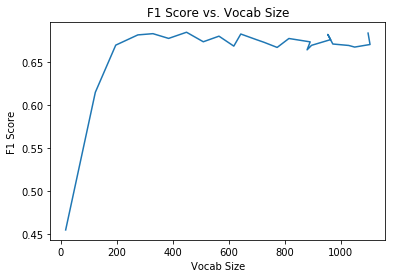

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    vectorizer = CountVectorizer()
    transformed_train_data = vectorizer.fit_transform(train_data)
    transformed_dev_data = vectorizer.transform(dev_data)
    original_vocab_size = transformed_train_data.shape[1]
    feature_names = vectorizer.get_feature_names()
    
    # L1 Logistic Regression model
    l1_logr = LogisticRegression(penalty='l1', C=0.5, tol=.01)
    l1_logr.fit(transformed_train_data, train_labels)
    original_f1_score = metrics.f1_score(dev_labels, l1_logr.predict(transformed_dev_data), average='weighted')
    print(f"L1 - F1 Score: {original_f1_score}, Vocab Size: {original_vocab_size}, Nonzero Weights: {np.count_nonzero(l1_logr.coef_)}")
    
    # L2 Logistic Regression model
    l2_logr = LogisticRegression(penalty='l2', C=0.5, tol=.01)
    l2_logr.fit(transformed_train_data, train_labels)
    original_f1_score = metrics.f1_score(dev_labels, l2_logr.predict(transformed_dev_data), average='weighted')
    print(f"L2 - F1 Score: {original_f1_score}, Vocab Size: {original_vocab_size}, Nonzero Weights: {np.count_nonzero(l2_logr.coef_)}")
    
    # Reduce Vocab to only nonzero weighted features
    nonzero_indexes = np.ndarray.nonzero(l1_logr.coef_)[1]
    nonzero_words = []
    for index in nonzero_indexes:
        nonzero_words.append(feature_names[index])
    
    # Remove duplicate words
    unique_nonzero_words = set(nonzero_words)
    
    # Retrain L2 Logistic Regression model
    reduced_vectorizer = CountVectorizer(vocabulary=unique_nonzero_words)
    reduced_transformed_train_data = reduced_vectorizer.fit_transform(train_data)
    reduced_transformed_dev_data = reduced_vectorizer.transform(dev_data)
    new_vocab_size = reduced_transformed_train_data.shape[1]
    
    l2_logr = LogisticRegression(penalty='l2', C=0.5, tol=.01)
    l2_logr.fit(reduced_transformed_train_data, train_labels)
    new_f1_score = metrics.f1_score(dev_labels, l2_logr.predict(reduced_transformed_dev_data), average='weighted')
    print(f"Reduced L2 - F1 Score: {new_f1_score}, Vocab Size: {new_vocab_size}")
    
    # Accuracy plot
    vocab_sizes = []
    f1_scores = []
    
    # Generate L1 Logistic Regression models with varying C values
    for c in np.linspace(0.01,1.0,25):
        l1_logr = LogisticRegression(penalty='l1', C=c, tol=.01)
        l1_logr.fit(transformed_train_data, train_labels)
        f1_score = metrics.f1_score(dev_labels, l1_logr.predict(transformed_dev_data), average='weighted')
        
        # Reduce Vocab to only nonzero weighted features
        nonzero_indexes = np.ndarray.nonzero(l1_logr.coef_)[1]
        nonzero_words = []
        for index in nonzero_indexes:
            nonzero_words.append(feature_names[index])

        # Remove duplicate words
        unique_nonzero_words = set(nonzero_words)
        
        # Retrain L2 Logistic Regression model
        reduced_vectorizer = CountVectorizer(vocabulary=unique_nonzero_words)
        reduced_transformed_train_data = reduced_vectorizer.fit_transform(train_data)
        reduced_transformed_dev_data = reduced_vectorizer.transform(dev_data)
        new_vocab_size = reduced_transformed_train_data.shape[1]
        vocab_sizes.append(new_vocab_size)

        l2_logr = LogisticRegression(penalty='l2', C=c, tol=.01)
        l2_logr.fit(reduced_transformed_train_data, train_labels)
        f1_score = metrics.f1_score(dev_labels, l2_logr.predict(reduced_transformed_dev_data), average='weighted')
        f1_scores.append(f1_score)
        
    plt.plot(vocab_sizes, f1_scores)
    plt.title('F1 Score vs. Vocab Size')
    plt.ylabel('F1 Score')
    plt.xlabel('Vocab Size')
    plt.show()
    
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [9]:
def P7():
    # Create TfidfVectorizer
    vectorizer = TfidfVectorizer()
    transformed_train_data = vectorizer.fit_transform(train_data)
    transformed_dev_data = vectorizer.transform(dev_data)
    vocab_size = transformed_train_data.shape[1]
    feature_names = vectorizer.get_feature_names()
    
    # Train model with new vocabulary
    l2_logr = LogisticRegression(penalty='l2', C=100)
    l2_logr.fit(transformed_train_data, train_labels)
    f1_score = metrics.f1_score(dev_labels, l2_logr.predict(transformed_dev_data), average='weighted')
    print(f"L2 LogR - F1 Score: {f1_score}, Vocab Size: {vocab_size}")
    
    # Calculate R values
    r_ratios = []
    for index, probabilities in enumerate(l2_logr.predict_proba(transformed_dev_data)):
        label = dev_labels[index]
        max_probability = float(probabilities.max())
        prob_of_correct_label = float(probabilities[label])
        new_r = max_probability / prob_of_correct_label
            
        r_ratios.append(new_r)

    # Output top 3 R values + documents
    top_3_r_ratios = sorted(r_ratios, key=float)[-3:]
    for r in top_3_r_ratios:
        index = r_ratios.index(r)
        print(f"R Ratio: {r}, Label: {newsgroups_train.target_names[dev_labels[index]]}, Document: \n{dev_data[index]}\n\n")
    
P7()

c:\software\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\software\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


L2 LogR - F1 Score: 0.7597662427853104, Vocab Size: 26879
R Ratio: 287.1793188826421, Label: alt.atheism, Document: 

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...



R Ratio: 324.98794366416473, Label: talk.religion.misc, Document: 
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.


R Ratio: 929.3437496709303, Label: talk.religion.misc, Document: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of 

#### ANSWER:  

The model with transformed data using TFIDF is making the mistake of confusing key words in multiple classes.  In particular, I noticed that both top 2 R Ratio documents have lots of references to Graphics terms, such as file extensions and web related nouns and verbs.  My suggestion to address this issue is use a bi and trigram vocabulary to try and provide some context to each feature instead of focusing on occurances of single words.  Additionally, preprocessing the documents when using CountVectorizer to reduce the overall feature space helped to generalize our model, so I would also suggest adding a preprocessor to TFIDFVectorizer.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [10]:
# Implementing bigram + preprocessor

# Add preprocessor used in P5
def better_preprocessor(s):
    lowercased = s.lower()
    remove_nonalphanumeric = re.sub('[!@#$%^&"`{}<>]', '', lowercased)
    
    shortened_words = []
    for word in remove_nonalphanumeric.split(' '):
        shortened_words.append(word[:100])
    shortened_words = ' '.join(shortened_words)
    
    preprocessed_string = shortened_words
    return preprocessed_string

# TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor=better_preprocessor, analyzer='word', ngram_range=(2,3))
transformed_train_data = vectorizer.fit_transform(train_data)
transformed_dev_data = vectorizer.transform(dev_data)
vocab_size = transformed_train_data.shape[1]
feature_names = vectorizer.get_feature_names()

# Train model with new vocabulary
l2_logr = LogisticRegression(penalty='l2', C=100)
l2_logr.fit(transformed_train_data, train_labels)
f1_score = metrics.f1_score(dev_labels, l2_logr.predict(transformed_dev_data), average='weighted')
print(f"L2 LogR - F1 Score: {f1_score}, Vocab Size: {vocab_size}")

# Calculate R values
r_ratios = []
for index, probabilities in enumerate(l2_logr.predict_proba(transformed_dev_data)):
    label = dev_labels[index]
    max_probability = float(probabilities.max())
    prob_of_correct_label = float(probabilities[label])
    new_r = max_probability / prob_of_correct_label

    r_ratios.append(new_r)

# Output top 3 R values + documents
top_3_r_ratios = sorted(r_ratios, key=float)[-3:]
for r in top_3_r_ratios:
    index = r_ratios.index(r)
    print(f"R Ratio: {r}, Label: {newsgroups_train.target_names[dev_labels[index]]}, Document: \n{dev_data[index]}\n\n")


c:\software\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\software\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


L2 LogR - F1 Score: 0.6706893987150258, Vocab Size: 509831
R Ratio: 92.39614874523332, Label: talk.religion.misc, Document: 
In <1ren9a$94q@morrow.stanford.edu> salem@pangea.Stanford.EDU (Bruce Salem) 



This brings up another something I have never understood.  I asked this once
before and got a few interesting responses, but somehow didn't seem satisfied.
Why would the NT NOT be considered a good source.  This might be a 
literary/historical question, but when I studied history I always looked for 
firsthand original sources to write my papers.  If the topic was on Mr. X, I 
looked to see if Mr. X wrote anything about it.  If the topic was on a group, 
look for the group, etc.  If the topic is on Mr. X, and Mr. X did not write 
anything about it, (barring the theistic response about the Bible being 
divinely inspired which I can't adequately argue), wouldn't we look for people
who ate, worked, walked, talked, etc. with him?  If someone was at an event 
wouldn't they be a better "rep

#### Extra Credit Analysis
As seen above, I was able to reduce the top 3 R Ratio values from 92.39, 324.98, and 929.34 to 92.39, 120.44, 183.81.  I interpret this is as the model not being as overly confident given that the R Ratio is lower in value.  It is worth noting that the original TFIDF model and new EC TFIDF Model both had the same Religion document (e.g. "Easy-to-Read Book of Mormon") in their top 3 R ratio documents.  Lastly, the accuracy of this new model fell from 0.759 to 0.671 F1 score.  